In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from scipy.stats import uniform, randint

from sklearn.preprocessing import StandardScaler



In [21]:
df = pd.read_csv('../data/processed/PS_20174392719_1491204439457_log.csv')

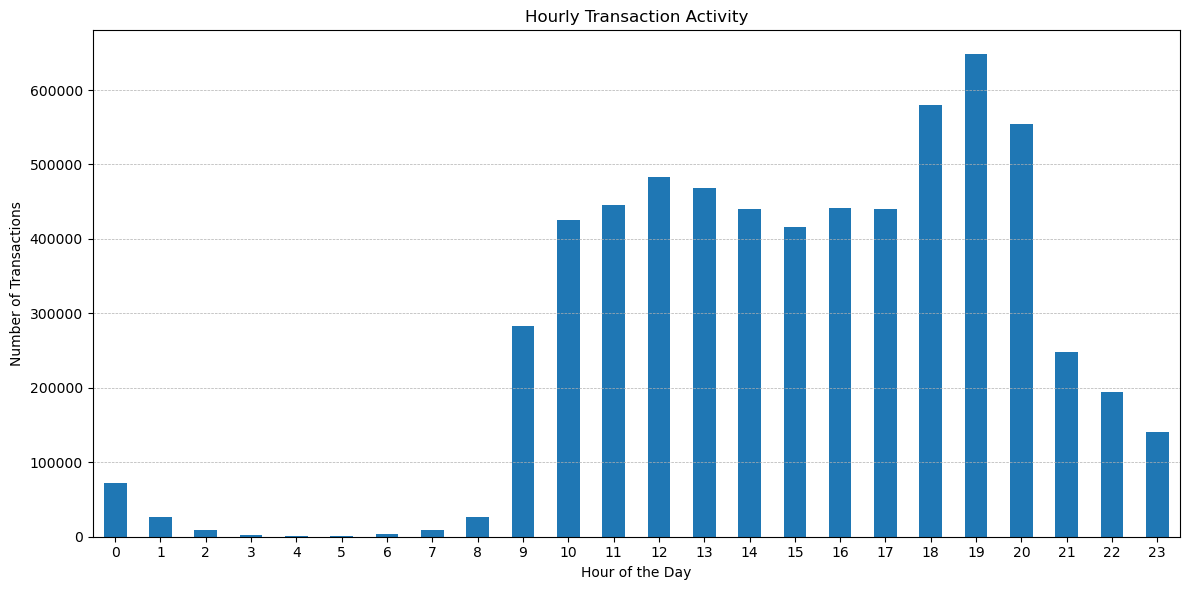

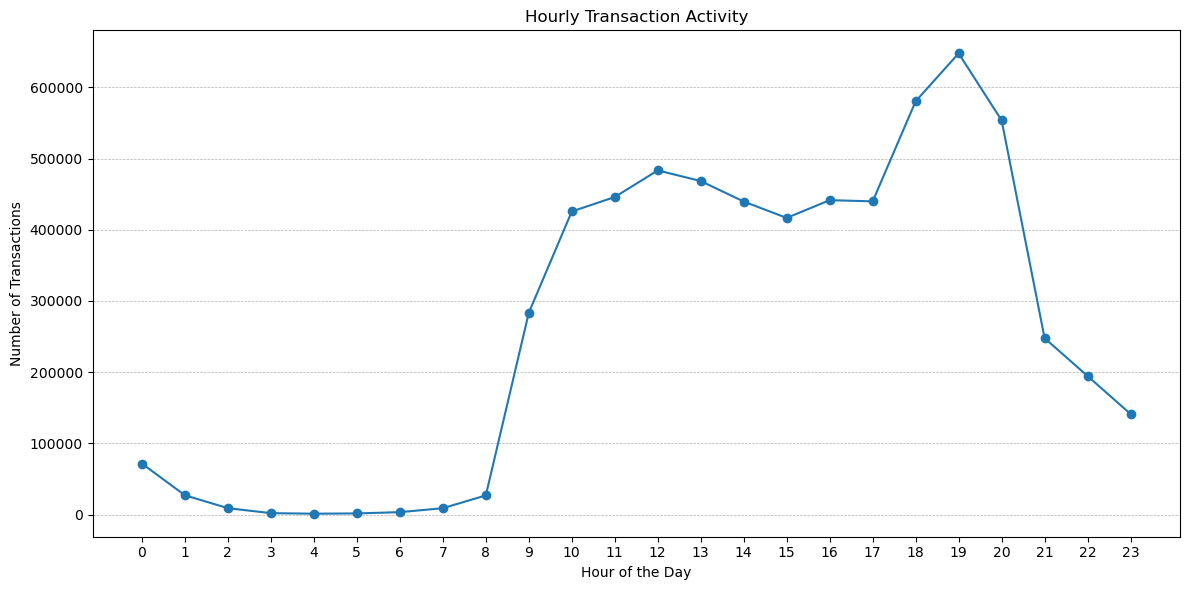

In [22]:
# groupby 'HourOfDay' to get the number of transactions per hour
hourly_transactions = df.groupby('HourOfDay').size()

# the hourly transactions / bar plot
plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='bar')
plt.title('Hourly Transaction Activity')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24), rotation=0)  # show every hour
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# line plot
plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='line', marker='o')
plt.title('Hourly Transaction Activity')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24), rotation=0)  # every hour
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

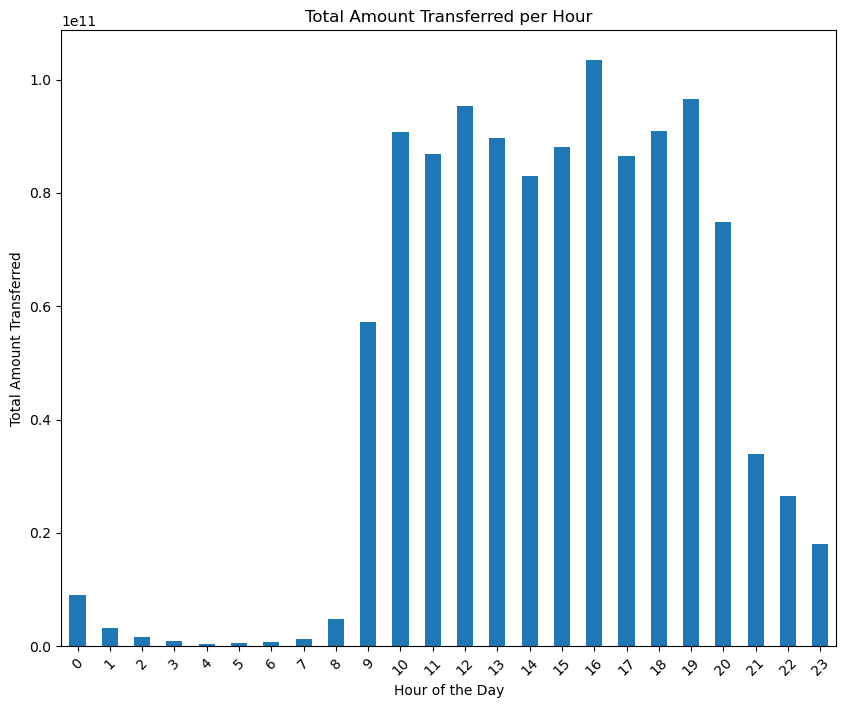

In [23]:
hourly_amount = df.groupby('HourOfDay')['amount'].sum()

plt.figure(figsize=(10, 8))  
hourly_amount.plot(kind='bar')  
plt.title('Total Amount Transferred per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Amount Transferred')
plt.xticks(rotation=45) 
plt.show()

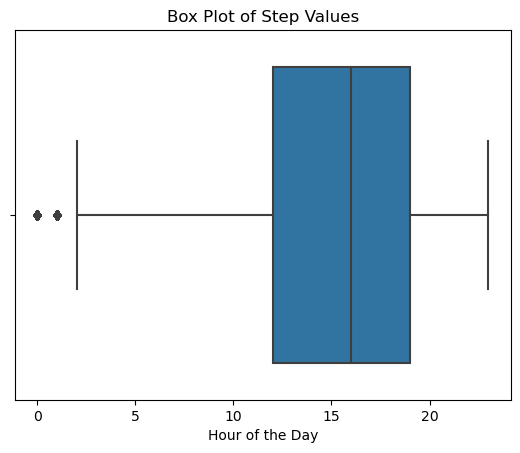

In [24]:
sns.boxplot(x=df['HourOfDay'])
plt.title('Box Plot of Step Values')
plt.xlabel('Hour of the Day')
plt.show()

## Modeling

In [25]:
# creating a random sample of 10%. dataset is too large
sample_df = df.sample(frac=0.1,random_state=42)

In [26]:
# split data into X and y 
X = sample_df.drop('isFraud', axis=1)
y = sample_df['isFraud']

# converts categorical variables for ML algorithms  
X = pd.get_dummies(X, columns=['type'])

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
# scaling the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest 

In [28]:
model = RandomForestClassifier(random_state=42)

# train the model
model.fit(X_train, y_train)

# predict on the test set
y_pred = model.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9997233852614638
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158865
           1       0.99      0.79      0.88       201

    accuracy                           1.00    159066
   macro avg       1.00      0.89      0.94    159066
weighted avg       1.00      1.00      1.00    159066



## Gradient Boosting

In [29]:
gb_class = GradientBoostingClassifier(random_state=42)

In [30]:
# train the model 
gb_class.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [39]:
# predictions
y_pred = gb_class.predict(X_test)

# the accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# classification report to see precision, recall, and F1-score
print(classification_report(y_test, y_pred))

# the confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Accuracy: 0.9995725044949895
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158865
           1       0.91      0.74      0.81       201

    accuracy                           1.00    159066
   macro avg       0.95      0.87      0.91    159066
weighted avg       1.00      1.00      1.00    159066

Confusion Matrix:
[[158850     15]
 [    53    148]]


In [32]:

# the hyperparameters distribution 
param_dist = {
    'n_estimators': randint(50, 300),  # number of trees between 50 and 500
    'learning_rate': uniform(0.01, 0.1),  # prevents overfitting
    'max_depth': randint(3, 10)  # max depth of each tree between 3 and 10 
}

random_search = RandomizedSearchCV(
    estimator=gb_class, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    random_state=42, 
    scoring='accuracy', 
    n_jobs=-1
)

# fitting data
random_search.fit(X_train, y_train)

# the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Best parameters: {'learning_rate': 0.02428668179219408, 'max_depth': 5, 'n_estimators': 199}
Best score: 0.9995389733717996


In [33]:
# best parameters
best_params = {
    'n_estimators': 199,
    'learning_rate': 0.02428668179219408,
    'max_depth': 5
}

In [34]:
# retraining with best parameters
gb_optimized = GradientBoostingClassifier(**best_params,random_state=42)

gb_optimized.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.02428668179219408, max_depth=5,
                           n_estimators=199, random_state=42)

In [37]:
# predictions with optimized model
y_pred_optimized = gb_optimized.predict(X_test)

#f1 score
f1_score_optimized = f1_score(y_test, y_pred_optimized)
f1_score_optimized


0.8169761273209549